In [1]:
import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
from pandas_datareader import data, DataReader
from datetime import datetime

gs = DataReader('GS',  'yahoo', datetime(2009, 1, 1), datetime(2019, 1, 1))
gs.reset_index(level=0, inplace=True)
gs.head(3)
gs[['Date', 'Adj Close']].rename(index=str, columns={'Adj Close': 'GS'}).to_csv('data/panel_data_close.csv',
                                                                       date_format='%Y-%m-%d', index=False)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2009-01-02,87.620003,82.190002,84.019997,86.760002,14088500.0,76.137115
1,2009-01-05,90.949997,85.459999,85.809998,88.779999,15996700.0,77.909775
2,2009-01-06,92.199997,87.720001,90.050003,88.709999,21551800.0,77.848366


In [4]:
def parser(x):
    return datetime.strptime(x,'%Y-%m-%d')
dataset_ex_df = pd.read_csv('data/panel_data_close.csv', header=0, parse_dates=[0], date_parser=parser)
dataset_ex_df[['Date', 'GS']].head(3)

,Date,GS
0,2009-01-02,76.137115
1,2009-01-05,77.909775
2,2009-01-06,77.848366


In [5]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2516 number of days in the dataset.


<Figure size 1400x500 with 0 Axes>

Text(0.5,0,'Date')

Text(0,0.5,'USD')

Text(0.5,1,'Figure 2: Goldman Sachs stock price')

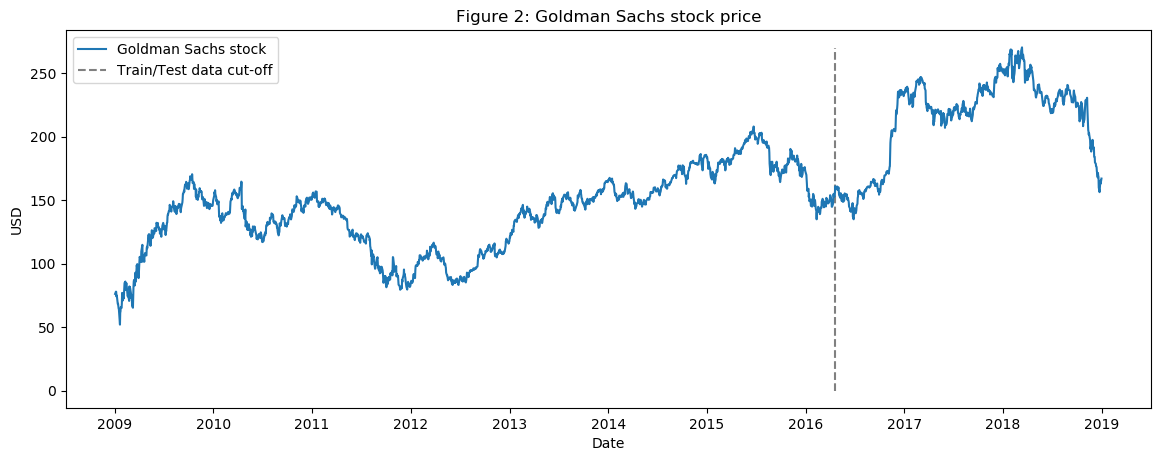

In [6]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['GS'], label='Goldman Sachs stock')
plt.vlines(datetime(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [7]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1761. Number of test days: 755.


## 3.2 Technical Indicator

In [8]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21).mean()
    
    # Create MACD
    #dataset['26ema'] = pd.DataFrame.ewma(dataset['price'], span=26)
    dataset['26ema'] = pd.DataFrame.ewm(dataset['price'], span=26).mean()
    #dataset['12ema'] = pd.DataFrame.ewma(dataset['price'], span=12)
    dataset['12ema'] = pd.DataFrame.ewm(dataset['price'], span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moment.rolling_std(dataset['price'],20)
    dataset['20sd'] = dataset['price'].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['price']-1
    
    return dataset

In [9]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['GS']].rename(index=str, columns={'GS': 'price'}))
dataset_TI_df.head(14)

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,76.137115,NaN,NaN,76.137115,76.137115,0.000000,NaN,NaN,NaN,76.137115,75.137115
1,77.909775,NaN,NaN,77.057535,77.097306,0.039771,NaN,NaN,NaN,77.466610,76.909775
2,77.848366,NaN,NaN,77.341673,77.390445,0.048772,NaN,NaN,NaN,77.730902,76.848366
3,74.153854,NaN,NaN,76.450498,76.368780,-0.081718,NaN,NaN,NaN,75.316395,73.153854
4,74.952431,NaN,NaN,76.103090,75.983963,-0.119127,NaN,NaN,NaN,75.072749,73.952431
5,73.644844,NaN,NaN,75.610723,75.415434,-0.195289,NaN,NaN,NaN,74.119505,72.644844
6,68.160118,74.686643,NaN,74.285671,73.796436,-0.489236,NaN,NaN,NaN,70.144763,67.160118
7,68.379486,73.578411,NaN,73.334039,72.666002,-0.668037,NaN,NaN,NaN,68.967732,67.379486
8,66.422531,71.937376,NaN,72.309602,71.430821,-0.878781,NaN,NaN,NaN,67.270845,65.422531
9,64.790260,70.071932,NaN,71.272006,70.172437,-1.099568,NaN,NaN,NaN,65.617094,63.790260


In [10]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    #plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

plot_technical_indicators(dataset_TI_df, 400)

## Fundamental Analysis

In [11]:
import gluonnlp as nlp

In [12]:
# just import bert
import bert

## Fourier Transform

' Code to create the Fuorier trasfrom  '

                                        fft
0                    (402015.9954185486+0j)
1  (24238.712996688708+55711.640764505624j)
2  (11187.697348528161+11734.186179206206j)


<Figure size 1400x700 with 0 Axes>

Text(0.5,0,'Days')

Text(0,0.5,'USD')

Text(0.5,1,'Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')

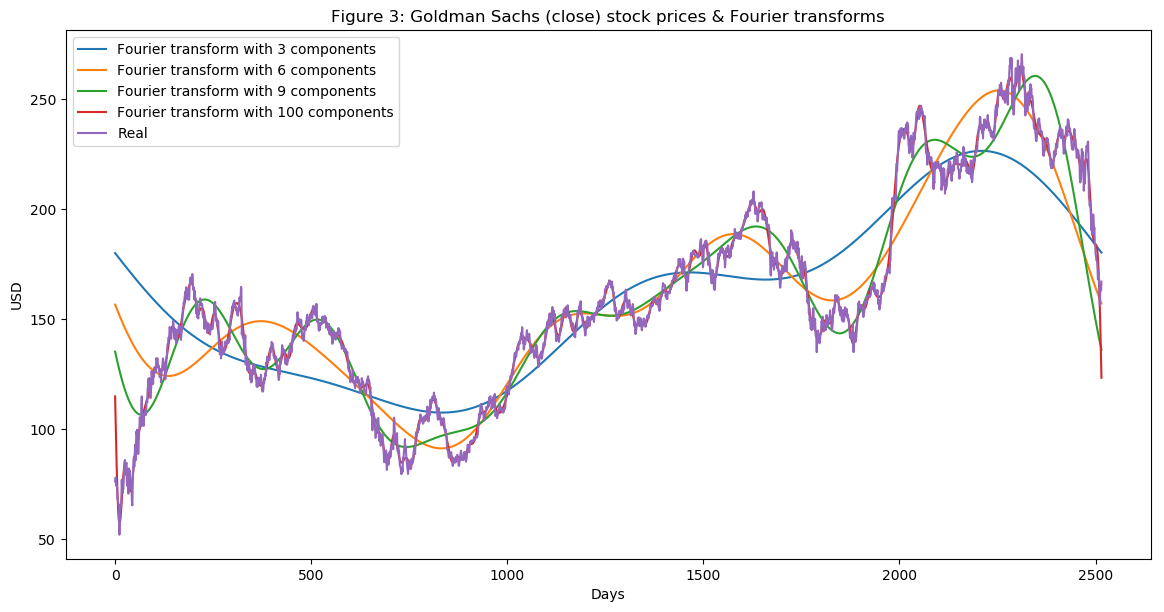

In [13]:
""" Code to create the Fuorier trasfrom  """
data_FT = dataset_ex_df[['Date', 'GS']]
close_fft = np.fft.fft(np.asarray(data_FT['GS'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
print(fft_df.head(3))
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['GS'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

<Figure size 800x560 with 0 Axes>

<StemContainer object of 3 artists>

Text(0.5,1,'Figure 4: Components of Fourier transforms')

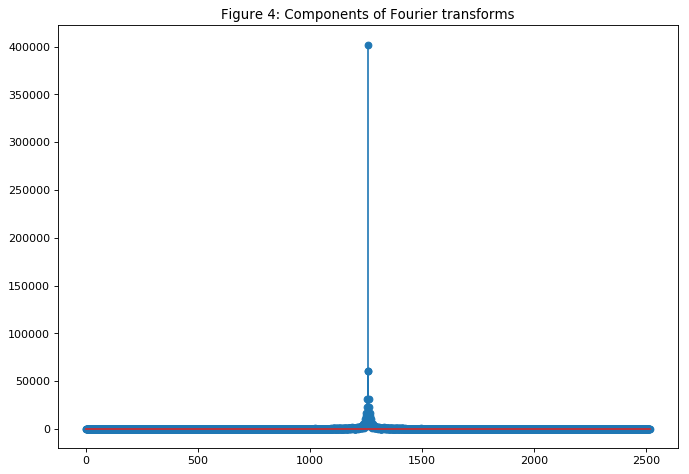

In [14]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

## ARIMA

In [15]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['GS']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.GS   No. Observations:                 2515
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -6043.312
Method:                       css-mle   S.D. of innovations              2.675
Date:                Sun, 27 Jan 2019   AIC                          12100.623
Time:                        02:57:57   BIC                          12141.434
Sample:                             1   HQIC                         12115.435
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0360      0.050      0.725      0.468      -0.061       0.133
ar.L1.D.GS    -0.0427      0.020     -2.143      0.032      -0.082      -0.004
ar.L2.D.GS     0.0091      0.020      0.454      0.6

<Figure size 800x560 with 0 Axes>

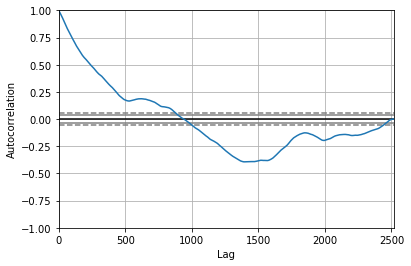

<Figure size 800x560 with 0 Axes>

In [16]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [17]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [18]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 9.751


<Figure size 1200x600 with 0 Axes>

Text(0.5,0,'Days')

Text(0,0.5,'USD')

Text(0.5,1,'Figure 5: ARIMA model on GS stock')

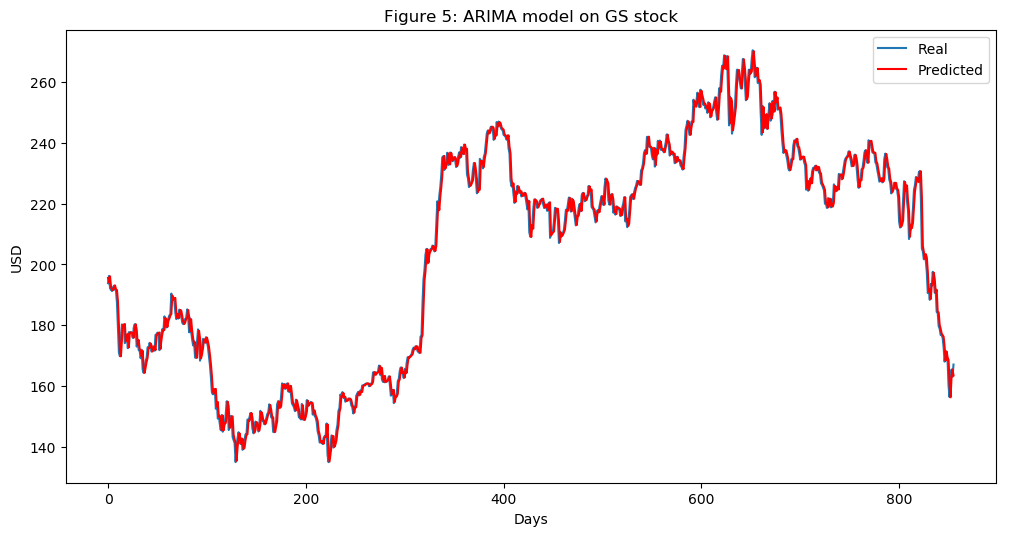

In [19]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

## Feature Engineer

In [21]:
#print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], dataset_total_df.shape[1]))

In [22]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['price']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)


In [23]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)

In [24]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [25]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(X_train_FI,y_train_FI, eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], verbose=False)

eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))


Text(0.5,0,'Iterations')

Text(0,0.5,'RMSE')

Text(0.5,1,'Training Vs Validation Error')

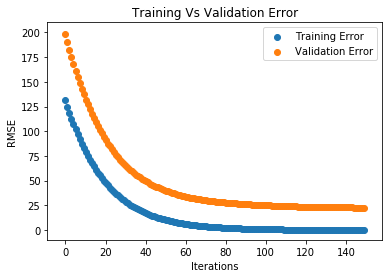

In [26]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

<BarContainer object of 10 artists>

Text(0.5,1,'Figure 6: Feature importance of the technical indicators.')

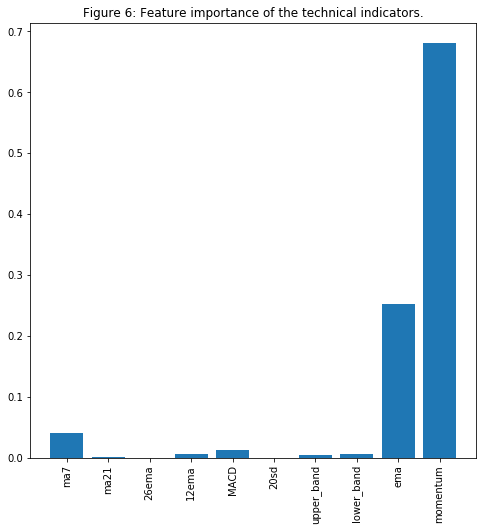

In [27]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

## Stacked Auto Encoder

In [28]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))
def relu(x):
    return max(x, 0)
def lrelu(x):
    return max(0.01*x, x)

<Figure size 1080x360 with 0 Axes>

Text(0.5,1,'Figure 7: GELU as an activation function for autoencoders')

Text(0,0.5,'f(x) for GELU and ReLU')

Text(0.5,0,'x')

Text(0,0.5,'f(x) for Leaky ReLU')

Text(0.5,0,'x')

Text(0.5,1,'Figure 8: LeakyReLU')

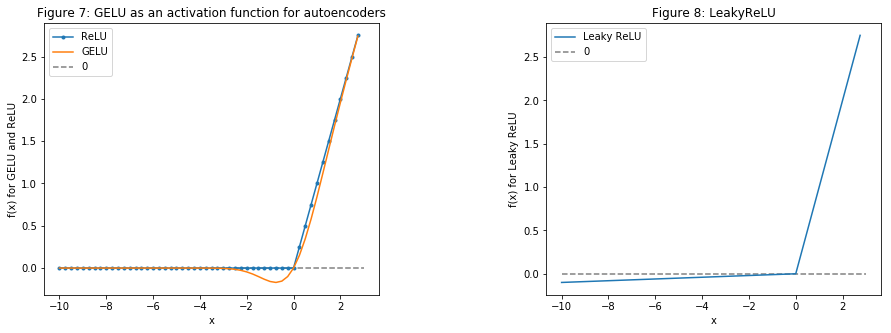

In [29]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()

In [31]:
batch_size = 64
n_batches = VAE_data.shape[0]/batch_size
VAE_data = VAE_data.values

train_iter = mx.io.NDArrayIter(data={'data': VAE_data[:num_training_days,:-1]}, \
                               label={'label': VAE_data[:num_training_days, -1]}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': VAE_data[num_training_days:,:-1]}, \
                              label={'label': VAE_data[num_training_days:,-1]}, batch_size = batch_size)

NameError: name 'VAE_data' is not defined

In [32]:
model_ctx =  mx.cpu()
class VAE(gluon.HybridBlock):
    def __init__(self, n_hidden=400, n_latent=2, n_layers=1, n_output=784, \
                 batch_size=100, act_type='relu', **kwargs):
        self.soft_zero = 1e-10
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.output = None
        self.mu = None
        super(VAE, self).__init__(**kwargs)
        
        with self.name_scope():
            self.encoder = nn.HybridSequential(prefix='encoder')
            
            for i in range(n_layers):
                self.encoder.add(nn.Dense(n_hidden, activation=act_type))
            self.encoder.add(nn.Dense(n_latent*2, activation=None))

            self.decoder = nn.HybridSequential(prefix='decoder')
            for i in range(n_layers):
                self.decoder.add(nn.Dense(n_hidden, activation=act_type))
            self.decoder.add(nn.Dense(n_output, activation='sigmoid'))

    def hybrid_forward(self, F, x):
        h = self.encoder(x)
        #print(h)
        mu_lv = F.split(h, axis=1, num_outputs=2)
        mu = mu_lv[0]
        lv = mu_lv[1]
        self.mu = mu

        eps = F.random_normal(loc=0, scale=1, shape=(self.batch_size, self.n_latent), ctx=model_ctx)
        z = mu + F.exp(0.5*lv)*eps
        y = self.decoder(z)
        self.output = y

        KL = 0.5*F.sum(1+lv-mu*mu-F.exp(lv),axis=1)
        logloss = F.sum(x*F.log(y+self.soft_zero)+ (1-x)*F.log(1-y+self.soft_zero), axis=1)
        loss = -logloss-KL

        return loss

In [33]:
n_hidden=400 # neurons in each layer
n_latent=2 
n_layers=3 # num of dense layers in encoder and decoder respectively
n_output=VAE_data.shape[1]-1 

net = VAE(n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, n_output=n_output, batch_size=batch_size, act_type='gelu')

NameError: name 'VAE_data' is not defined

In [34]:
net.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu())
net.hybridize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})

NameError: name 'net' is not defined

In [35]:
print(net)

NameError: name 'net' is not defined

In [36]:
n_epoch = 150
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []
for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    train_iter.reset()
    test_iter.reset()

    n_batch_train = 0
    for batch in train_iter:
        n_batch_train +=1
        data = batch.data[0].as_in_context(mx.cpu())

        with autograd.record():
            loss = net(data)
        loss.backward()
        trainer.step(data.shape[0])
        epoch_loss += nd.mean(loss).asscalar()

    n_batch_val = 0
    for batch in test_iter:
        n_batch_val +=1
        data = batch.data[0].as_in_context(mx.cpu())
        loss = net(data)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)
    
    """if epoch % max(print_period, 1) == 0:
        print('Epoch {}, Training loss {:.2f}, Validation loss {:.2f}'.\
              format(epoch, epoch_loss, epoch_val_loss))"""

end = time.time()
print('Training completed in {} seconds.'.format(int(end-start)))

NameError: name 'train_iter' is not defined

In [37]:
dataset_total_df['Date'] = dataset_ex_df['Date']

NameError: name 'dataset_total_df' is not defined

In [38]:
vae_added_df = mx.nd.array(dataset_total_df.iloc[:, :-1].values)

NameError: name 'dataset_total_df' is not defined

In [39]:
print('The shape of the newly created (from the autoencoder) features is {}.'.format(vae_added_df.shape))


NameError: name 'vae_added_df' is not defined

## PCA

In [40]:
# We want the PCA to create the new components to explain 80% of the variance
pca = PCA(n_components=.8)

In [41]:
x_pca = StandardScaler().fit_transform(vae_added_df)
principalComponents = pca.fit_transform(x_pca)
principalComponents.n_components_

NameError: name 'vae_added_df' is not defined